In [66]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tqdm import tqdm
import seaborn as sns
from implicit.nearest_neighbours import bm25_weight
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

In [52]:
# import transactions, customer and article data
df_trans = pd.read_csv('../data/transactions_train.csv', parse_dates=[0], dtype={'article_id':'string'})
df_art = pd.read_csv('../data/articles.csv', dtype={'article_id':'string'})
df_customers = pd.read_csv('../data/customers.csv')

In [53]:
# exclude parts of the data to reduce computational expense
# test period
#df = df_trans.query('t_dat <= "2020-09-15"').copy()
df = df_trans.copy()

# exclude users with less than 5 items in history
#n_items_per_user = df.groupby('customer_id').count().article_id.rename('n_items')
#df['n_items'] = df.customer_id.map(n_items_per_user)
#df = df[df.loc[:, 'n_items'] > 4]

# keep only users that have bought between 10 and 90 % of their items online
#n_items_per_channel = df.groupby(['customer_id', 'sales_channel_id']).count().article_id
#tmp1 = n_items_per_channel.reset_index().query('sales_channel_id == 1').set_index('customer_id').article_id.rename('offline_items')
#tmp2 = n_items_per_channel.reset_index().query('sales_channel_id == 2').set_index('customer_id').article_id.rename('online_items')
#online_fac = pd.concat([tmp1, tmp2], axis=1).fillna(0.0)
#online_fac['online_fac'] = online_fac.online_items/(online_fac.online_items + online_fac.offline_items)
#df['online_fac'] = df.customer_id.map(online_fac.online_fac).fillna(0.0)
#df = df.query('online_fac > 0.1 and online_fac < 0.9').copy()

In [54]:
df.customer_id.nunique()

1362281

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        string        
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), string(1)
memory usage: 1.2+ GB


In [56]:
# reduce data further by random sampling of users
#user_sample = df.groupby('customer_id').sum().sample(371827, random_state=42) #371827
#df = df.set_index('customer_id').loc[user_sample.index].reset_index()
# now count the number of times a customer bought an item
#_ = df.groupby(['customer_id', 'article_id']).count().price.rename('interactions')
#df['interactions'] = df.set_index(['customer_id', 'article_id']).index.map(_)
df_int = df.groupby(['customer_id', 'article_id']).t_dat.count().reset_index()
df_int.rename(columns={'t_dat':'interactions'}, inplace=True)

In [57]:
n_users = df_int.customer_id.nunique()
n_items = df_int.article_id.nunique()
n_records = len(df)
print(f'Sample size: {n_users} user and {n_items} items in {n_records} transactions.')
print(f'Sum of interactions: {df_int.interactions.sum()}')

Sample size: 1362281 user and 104547 items in 31788324 transactions.
Sum of interactions: 31788324


In [58]:
# create utility matrix Y
# rows represent items, columns represent users
# note: users with no transactions and items never sold are not included
n_users = df_int.customer_id.nunique()
n_items = df_int.article_id.nunique()
user_ids = df_int.customer_id.unique()
item_ids = df_int.article_id.unique()

item_id_map = dict([(item_id, i) for i, item_id in enumerate(item_ids)])
item_id_map_rev = dict([(i, item_id) for i, item_id in enumerate(item_ids)])
user_id_map = dict([(user_id, j) for j, user_id in enumerate(user_ids)])
user_id_map_rev = dict([(j, user_id) for j, user_id in enumerate(user_ids)])

df_int['i'] = df_int.article_id.apply(lambda id: item_id_map[id])
df_int['j'] = df_int.customer_id.apply(lambda id: user_id_map[id])

# create sparse matrix
Y = coo_matrix((df_int.interactions, (df_int['i'], df_int['j'])), shape=(n_items,n_users))
Y = bm25_weight(Y, K1=100, B=0.8)
Y_csr = Y.T.tocsr()


In [59]:
Y = coo_matrix((df_int.interactions, (df_int['i'], df_int['j'])), shape=(n_items,n_users))
Y = bm25_weight(Y, K1=2, B=0.75) #100 0.8
Y_csr = Y.T.tocsr()

In [39]:
print(Y_csr[Y_csr>0].mean(), Y_csr[Y_csr>0].max(), Y_csr[Y_csr>0].std())

4.739839193323544 31.610935360343674 3.735291658526431


In [20]:
Y_csr[Y_csr > 0].max()

517.0088064717003

In [60]:
# check sparsity ratio
n_total = Y.shape[0]*Y.shape[1]
n_ratings = Y.nnz
sparsity = n_ratings/n_total
print('Matrix sparsity: ', round(sparsity*100, 2))

Matrix sparsity:  0.02


In [46]:
model = AlternatingLeastSquares(factors=640, regularization=0.05, num_threads=0, iterations=30)
model.fit(2 * Y_csr)

100%|██████████| 30/30 [16:17<00:00, 32.58s/it]


In [61]:
model = BayesianPersonalizedRanking(factors=640, regularization=0.05, num_threads=0, iterations=30)
model.fit(Y_csr)

100%|██████████| 30/30 [07:24<00:00, 14.82s/it, train_auc=52.62%, skipped=0.43%]


In [67]:
model = LogisticMatrixFactorization(factors=640, regularization=0.05, num_threads=0)
model.fit(Y_csr)

100%|██████████| 30/30 [28:21<00:00, 56.71s/it]


In [19]:
#user_id = user_ids[0]
#print(len(user_ids), user_id)
#print(Y_csr.shape, Y_csr[user_id_map[user_id], :])
#ids, scores = model.recommend(user_id_map[user_id], Y_csr[user_id_map[user_id]], N=12, filter_already_liked_items=False)

In [20]:
#items = [item_id_map_rev[idx] for idx in ids]

In [68]:
# predict full batch of users
user_idx = [user_id_map[id] for id in user_ids]
ids, scores = model.recommend(user_idx, Y_csr[user_idx], N=12, filter_already_liked_items=False)

In [69]:
# convert from matrix indices to item ids
tmp = pd.DataFrame(ids, index=user_ids)
tmp = tmp.apply(lambda s: ' '.join(s.apply(lambda id: item_id_map_rev[id])), axis=1)

In [70]:
# make frame containing all available individualized recommendations and join with customer table
submission = pd.DataFrame({'prediction':tmp}, index=user_ids)
submission = df_customers.join(submission, on='customer_id', how='left').set_index('customer_id')
# now fill empty predictions with baseline
baseline_prediction = '0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'
submission.fillna(baseline_prediction, inplace=True)


In [71]:
submission.loc[:, 'prediction'].to_csv('../data/lma640fac_test.csv')

In [15]:
submission.prediction.nunique()

99999

In [87]:
# compute distance matrix
D_csr = cosine_similarity(Y_csr, dense_output=False)

In [88]:
def recommend_from_item(item_id, item_id_map, item_id_map_rev, D, k=12):
    i = item_id_map[item_id]
    distances = np.array(D[i, :].todense()).flatten()
    distances_idx = distances.argsort()[::-1]
    best_items_idx = distances_idx[1:k+1]
    best_items = [item_id_map_rev[id] for id in best_items_idx] 
    return ' '.join(best_items)

In [89]:
# predict similar items
item_predictions = pd.DataFrame({'prediction':item_ids}, index=item_ids)
item_predictions.prediction = item_predictions.prediction.apply(lambda id: recommend_from_item(id, item_id_map, item_id_map_rev, D_csr, k=12))


In [90]:
item_predictions.prediction.nunique()

82152

In [91]:
# compute wardrobe and dates for all customers, remove item ids that can't be predicted
df_trans.t_dat = df_trans.t_dat.dt.strftime('%Y-%m-%d')
wardrobe = df_trans[df_trans.article_id.isin(item_ids)].groupby('customer_id').article_id.agg(lambda id: ' '.join(id))
wardrobe_dates = df_trans[df_trans.article_id.isin(item_ids)].groupby('customer_id').t_dat.agg(lambda id: ' '.join(id))
df_wardrobe = pd.DataFrame({'dates':wardrobe_dates.astype('string'), 'wardrobe':wardrobe})

In [92]:
df_wardrobe = df_customers.join(df_wardrobe, on='customer_id', how='left').set_index('customer_id')

In [93]:
df_wardrobe.wardrobe = df_wardrobe.fillna('').wardrobe

In [94]:
baseline = '0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'.split(' ')

In [95]:
def predict_from_wardrobe(user_id, df_wardrobe, baseline, k=12):
    wardrobe = df_wardrobe.loc[user_id, 'wardrobe']
    if wardrobe == '':
        # cold start
        prediction = baseline
    else:
        # convert wardrobe to list with newest items first
        wardrobe = wardrobe.split(' ')[::-1]
        n_items = len(wardrobe)
#        i = 0
        # simplest most possible way: predict k items based on latest purchase
        item_id = wardrobe[0]
        # iterate through wardrobe starting with the newest item
        # for the i-th item use the most similar item as prediction if possible
        # repeat until k predictions have been made or wardrobe is depleted
        # if needed start over using the 2nd-most similar items as candidates
        i = 0
        prediction = []
        pos = 0
        while (pos < 2):            
            item_id = wardrobe[i]
            i = (i + 1) % n_items
            if i == 0:
                pos += 1
            best_items = recommend_from_item(item_id, item_id_map, item_id_map_rev, D_csr, k=pos+1).split(' ')
            pred_id = best_items[pos]
            if (len(prediction) < k) and (pred_id not in prediction) and (pred_id not in wardrobe):                    
                prediction.append(pred_id)

        # fill up with baseline if needed
        if len(prediction) < k:
            prediction.extend(baseline[0:(k-len(prediction))])
        if (len(prediction) < k) or (len(prediction) > k):
            raise Exception(f'FUCK! {k}')
        #prediction = recommend_from_item(item_id, item_id_map, item_id_map_rev, D_csr, k=k).split(' ')
#        q = max(k//n_items, 4)
#        while (len(prediction) < k) and (i < n_items):
#            item_id = wardrobe[i]
#            best_items = recommend_from_item(item_id, item_id_map, item_id_map_rev, D_csr, k=12).split(' ')
#            while (len(prediction) < min(q, k)) and len(best_items) > 0:
#                item_id = best_items.pop(0)
                # recommend item if its not in wardrobe and hasn't already been recommended
#                if (item_id not in prediction) and (item_id not in wardrobe):
#                    prediction.append(item_id)
#            i += 1
#            q += q        
#        if len(prediction) < k:
#            print('Warning: incomplete predictions...')
    return ' '.join(prediction)

In [96]:
def predict_from_wardrobe2(user_id, item_predictions, df_wardrobe, baseline, k=12):
    wardrobe = df_wardrobe.loc[user_id, 'wardrobe']
    if wardrobe == '':
        # cold start
        candidates = baseline
    else:
        # convert wardrobe to list with newest items first
        wardrobe = wardrobe.split(' ')[::-1]
        n_items = len(wardrobe) 
        wardrobe = wardrobe[0:max(12, n_items)]       
        # query precomputed item predictions for the users wardrobe
        tmp = item_predictions.loc[wardrobe] 
        rows = [pred.split(' ') for pred in tmp.prediction.values]
        # compile candidates for predictions in order
        tmp = pd.DataFrame(rows)
        candidates = []
        # maximum similarity level up to which a recommendation is considered
        r = 2
        # start with the items closest to the wardrobe items, up to the r-th most similar items
        for i in range(r):
            candidates.extend(tmp.iloc[:,i])
        # add baseline as safety net
        candidates.extend(baseline)
        candidates = pd.DataFrame({'prediction':candidates})        
        candidates = candidates.prediction.unique()
    return ' '.join(candidates[0:12])
        


In [97]:
# make predictions for all users
tmp = df_wardrobe.copy()
tmp2 = tmp.reset_index().customer_id.apply(lambda id: predict_from_wardrobe2(id, item_predictions, df_wardrobe, baseline, k=12))
tmp2 = pd.DataFrame({'customer_id':df_wardrobe.reset_index().customer_id, 'prediction':tmp2}).set_index('customer_id')
df_wardrobe['prediction'] = tmp2.prediction


In [45]:
user_id = df_customers.iloc[0].customer_id
%timeit predict_from_wardrobe(user_id, df_wardrobe, baseline, k=12)

65.8 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
%timeit predict_from_wardrobe2(user_id, item_predictions, df_wardrobe, baseline, k=12)

17.6 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
wardrobe = df_wardrobe.loc[user_id, 'wardrobe']
wardrobe = wardrobe.split(' ')[::-1]
tmp = item_predictions.loc[wardrobe, 'prediction'] 

 #       rows = [pred.split(' ') for pred in tmp.values]
 #       # compile candidates for predictions in order
 #       tmp = pd.DataFrame(rows)
 #       candidates = []
 #       # maximum similarity level to which a recommendation is considered
 #       r = 2
 #       # start with the items closest to the wardrobe items, up to the r-th most similar items
 #       for i in range(r):
 #           candidates.extend(tmp.iloc[:,i])
 #       # add baseline as safety net
 #       candidates.extend(baseline)
 #       candidates = pd.DataFrame({'prediction':candidates})        
 #       candidates = candidates.prediction.unique()

In [66]:
wardrobe

['0568601043',
 '0859416011',
 '0795440001',
 '0890498002',
 '0887593002',
 '0841260003',
 '0812683013',
 '0785710001',
 '0694736004',
 '0785186005',
 '0797065001',
 '0797065001',
 '0656719005',
 '0745232001',
 '0607642008',
 '0568601006',
 '0568601006',
 '0697138006',
 '0627759010',
 '0176209023',
 '0625548001']

In [65]:
item_predictions.loc[wardrobe, 'prediction']

0568601043    0779781015 0858856005 0697138006 0941358001 07...
0859416011    0816759001 0307239005 0544829002 0327368019 06...
0795440001    0808002001 0862636001 0611522013 0569093024 06...
0890498002    0679116001 0624761002 0829646007 0697138006 05...
0887593002    0883689001 0849312001 0855792001 0868507001 02...
0841260003    0838801003 0846347005 0828465002 0820866008 06...
0812683013    0700966004 0921033006 0495685015 0653706029 07...
0785710001    0761278001 0777136004 0852341002 0802284001 08...
0694736004    0738672001 0581331001 0753322015 0831267001 06...
0785186005    0703497004 0480627025 0612050001 0611547002 07...
0797065001    0697138006 0763382002 0713218001 0501123001 07...
0797065001    0697138006 0763382002 0713218001 0501123001 07...
0656719005    0658627002 0580853001 0815669004 0580853002 06...
0745232001    0713937001 0703761009 0722177004 0670954003 08...
0607642008    0520175011 0843991001 0735979001 0510407055 08...
0568601006    0507910001 0507909021 0759

In [71]:
%timeit item_predictions.loc[wardrobe]

17.4 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
item_id = wardrobe[0]
%timeit recommend_from_item(item_id, item_id_map, item_id_map_rev, D_csr, k=12)

1.17 ms ± 338 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [642]:
tmp2.head()

,prediction
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0874054001 0688873020 0662344015 0662344008 07...
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0458543009 0399061015 0790880002 0695814001 06...
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0925472001 0827681001 0579751005 0844967008 03...
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0732413001 0564313017 0564314019 0782451007 02...
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0639838017 0764374001 0612358004 0702634002 06...


In [98]:
# save to csv
#df_wardrobe.loc[:, 'prediction'] = df_wardrobe.loc[:, 'prediction'].apply(lambda l: ' '.join(l))
df_wardrobe.loc[:, 'prediction'].to_csv('../data/cf-item-item-100000-users-all-wardrobe_submission.csv')

In [151]:
len(df_wardrobe[df_wardrobe.loc[:, 'prediction'] == ' '.join(baseline)]) 

9872

In [107]:
# pick any article
article_id = item_ids[37000]
article_name = df_art.query('article_id == @article_id').prod_name.values[0]
print(article_name)

Reagan SS solid


In [108]:
similar_items = item_predictions.loc[article_id].prediction.split(' ') 

In [109]:
item_names = dict(zip(df_art.article_id, df_art.prod_name))

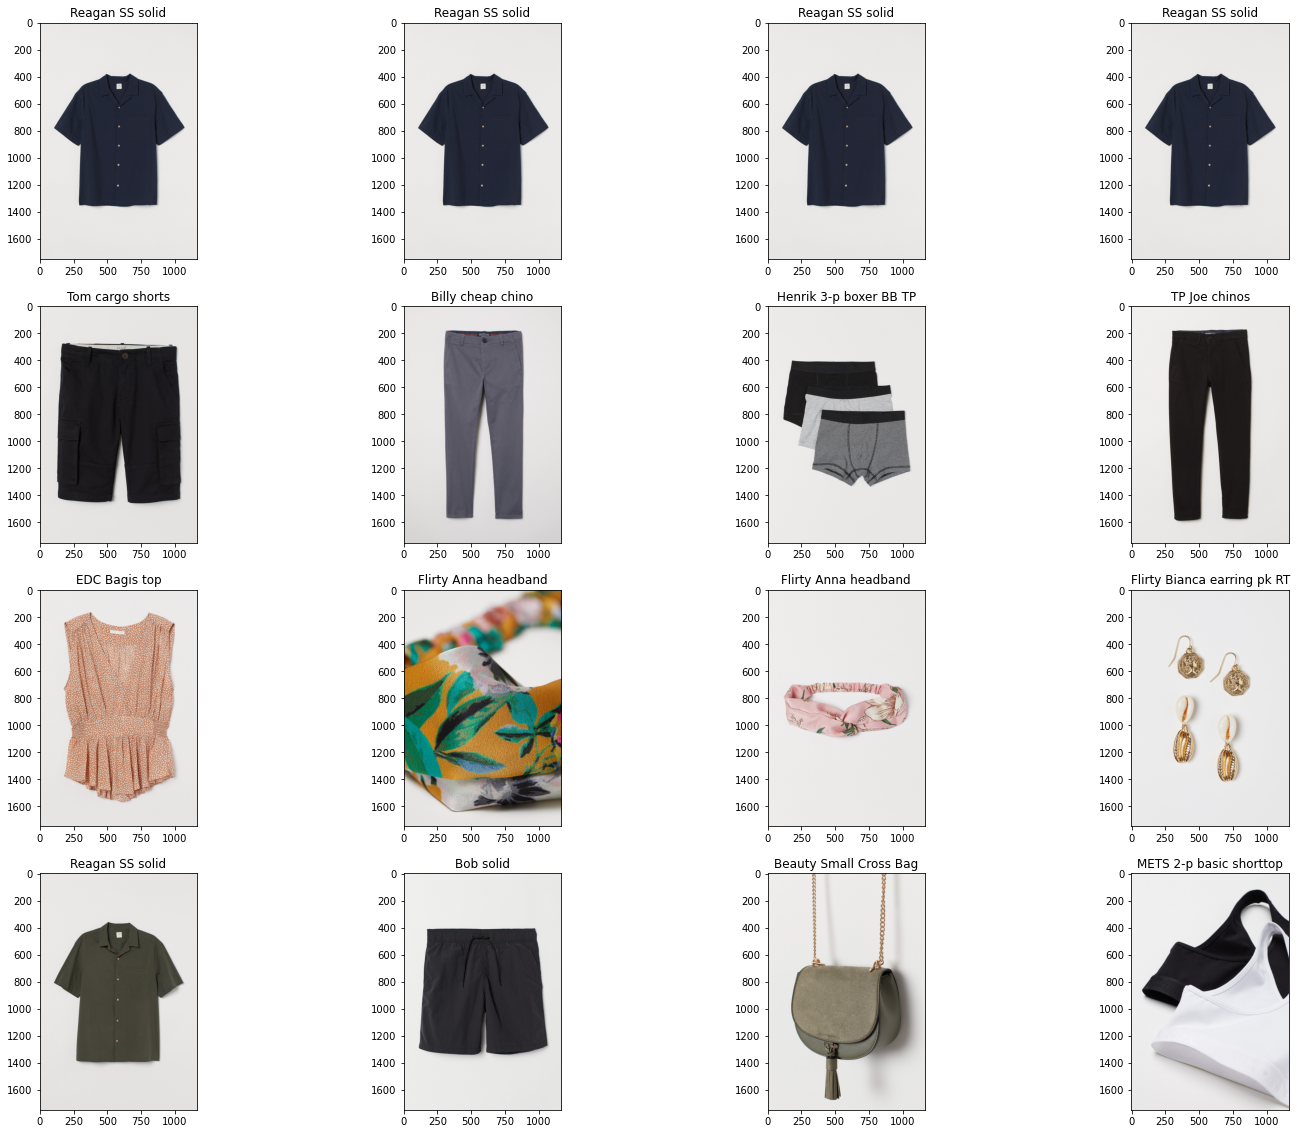

In [110]:
# display results
fig, axs = plt.subplots(4, 4, figsize=(25, 20))
c = 0
for i in range(4):
    for j in range(4):
        ax = axs[i][j]
        if i == 0:
            ax.set_title(article_name)
            fname = article_id + '.jpg'
            subdir = fname[0:3]
            full_path = os.path.join('../data', 'images', subdir, fname)
        else:
            fname = similar_items[c] + '.jpg'
            subdir = fname[0:3]
            full_path = os.path.join('../data', 'images', subdir, fname)
            ax.set_title(item_names[similar_items[c]])
            c += 1
         
        if os.path.exists(full_path):
            img = mpimg.imread(full_path)
            ax.imshow(img)

In [65]:
sub1 = pd.read_csv('../data/cf-item-item-1000-users_submission.csv', index_col=0)

In [67]:
sub1.query('prediction == ""').head()

,prediction
customer_id,
